### ```Predicting Ethereum Prices in USD for the next 30 Days``` ###

In [54]:
import requests as req
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from api import key # api key is from cryptocompare.com

# api key, symbol, currency, and limit
API, SYM, CUR, LIM = key, "ETH", "USD", 2000

resp = req.get(f"https://min-api.cryptocompare.com/data/v2/histoday?fsym={SYM}&tsym={CUR}&limit={LIM}&api_key={API}")

In [38]:
# convert response to json
data = resp.json()
# convert json to dataframe
df = pd.DataFrame(data["Data"]["Data"])
# convert unix time to datetime
df["time"] = pd.to_datetime(df["time"], unit="s")
# set time as index
df.set_index("time", inplace=True)
# drop unnecessary columns
df = df[['close']]
# rename close to price
df = df.rename(columns={'close': 'price'})

In [39]:
df

,price
time,
2017-10-23,285.27
2017-10-24,296.50
2017-10-25,296.35
2017-10-26,295.54
2017-10-27,296.36
...,...
2023-04-11,1891.58
2023-04-12,1918.78
2023-04-13,2013.84


##### Get Linear Regression Model

In [46]:
# Split data into training and testing sets
train = np.array(range(len(df))).reshape(-1, 1)
test = np.array(df['price'])
train_data_X, _, train_data_Y, _ = train_test_split(train, test, test_size=0.2, shuffle=False)

# Train linear regression model
lin_model = LinearRegression()
lin_model.fit(train_data_X, train_data_Y)

LinearRegression()

### Plot Historical Statistics and Predicted Values

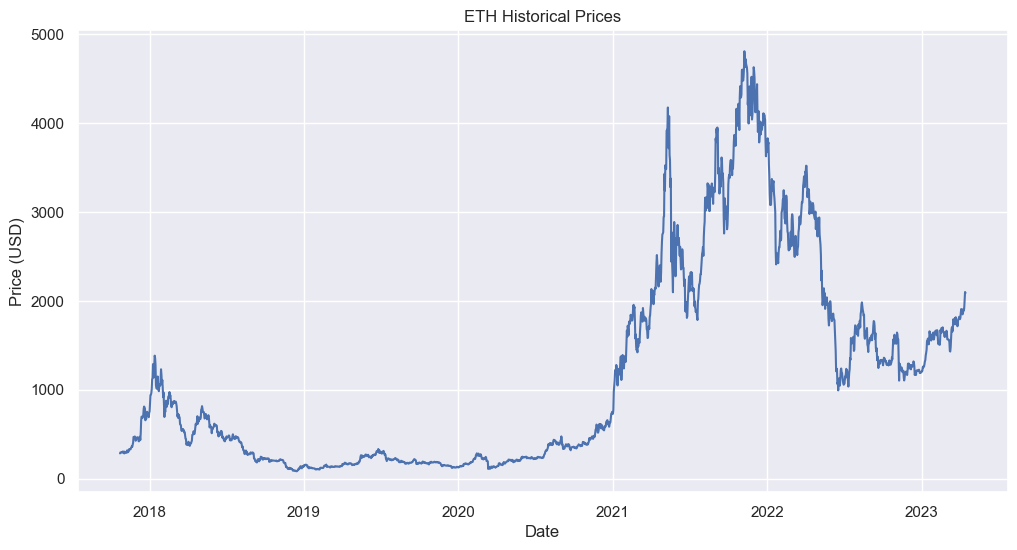

In [47]:
# Plot historical prices
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
sns.lineplot(data=df, x=df.index, y="price")
plt.xlabel('Date')
plt.ylabel(f'Price ({CUR})')
plt.title(f'{SYM} Historical Prices')
plt.show()

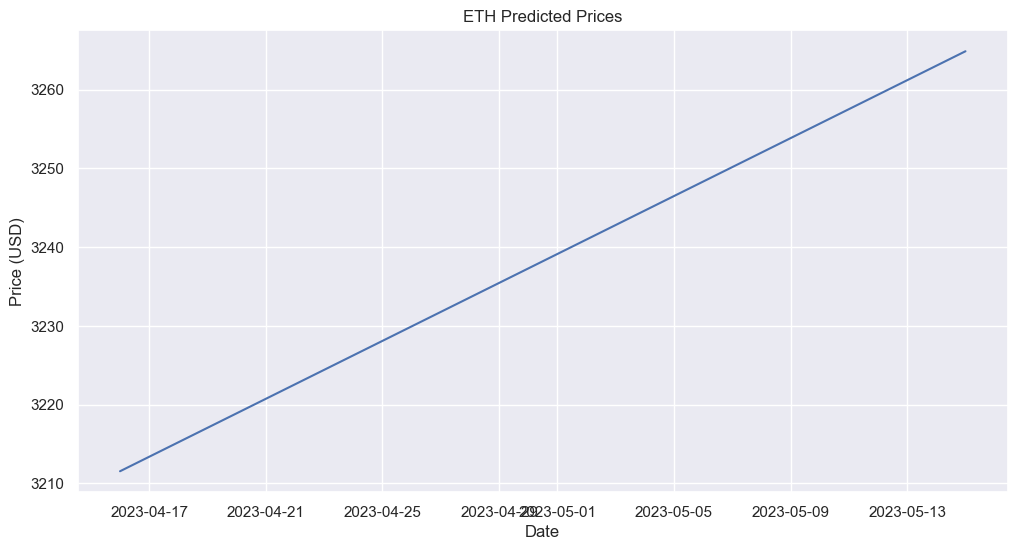

In [48]:
month = 30
future_dates = pd.date_range(start=df.index[-1], periods=month + 1, freq='D')[1:]
future_X = np.array(range(len(df), len(df) + month)).reshape(-1, 1)
future_y = lin_model.predict(future_X)

# Plot predicted prices
plt.figure(figsize=(12,6))
sns.set(style="darkgrid")
sns.lineplot(x=future_dates, y=future_y)
plt.xlabel('Date')
plt.ylabel(f'Price ({CUR})')
plt.title(f'{SYM} Predicted Prices')
plt.show()

### Using ANN **(Artificial Neural Network)** Model

In [49]:
scale = MinMaxScaler(feature_range=(0, 1))
data = scale.fit_transform(df.values)

train_size = int(len(data) * 0.8)
train_data = data[:train_size]
test_data = data[train_size:]

def create_dataset(data, look_back=1):
    X, Y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back), 0])
        Y.append(data[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
X_train, y_train = create_dataset(train_data, look_back)
X_test, y_test = create_dataset(test_data, look_back)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

seq_model = Sequential()
seq_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
seq_model.add(Dropout(0.2))
seq_model.add(LSTM(units=50, return_sequences=True))
seq_model.add(Dropout(0.2))
seq_model.add(LSTM(units=50))
seq_model.add(Dropout(0.2))
seq_model.add(Dense(units=1))
seq_model.compile(optimizer='adam', loss='mean_squared_error')

seq_model.fit(X_train, y_train, epochs=100, batch_size=32)

y_pred = seq_model.predict(X_test)
y_pred = scale.inverse_transform(y_pred)
y_test = scale.inverse_transform(y_test.reshape(-1, 1))

Epoch 1/100
49/49 [==============================] - 6s 41ms/step - loss: 0.0133
Epoch 2/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0039
Epoch 3/100
49/49 [==============================] - 2s 48ms/step - loss: 0.0033
Epoch 4/100
49/49 [==============================] - 3s 51ms/step - loss: 0.0038
Epoch 5/100
49/49 [==============================] - 2s 43ms/step - loss: 0.0029
Epoch 6/100
49/49 [==============================] - 2s 46ms/step - loss: 0.0032
Epoch 7/100
49/49 [==============================] - 2s 46ms/step - loss: 0.0025
Epoch 8/100
49/49 [==============================] - 3s 51ms/step - loss: 0.0027
Epoch 9/100
49/49 [==============================] - 2s 50ms/step - loss: 0.0024
Epoch 10/100
49/49 [==============================] - 3s 52ms/step - loss: 0.0023
Epoch 11/100
49/49 [==============================] - 2s 50ms/step - loss: 0.0021
Epoch 12/100
49/49 [==============================] - 2s 50ms/step - loss: 0.0025
Epoch 13/100
49/49 [=====

#### Graph using ANN

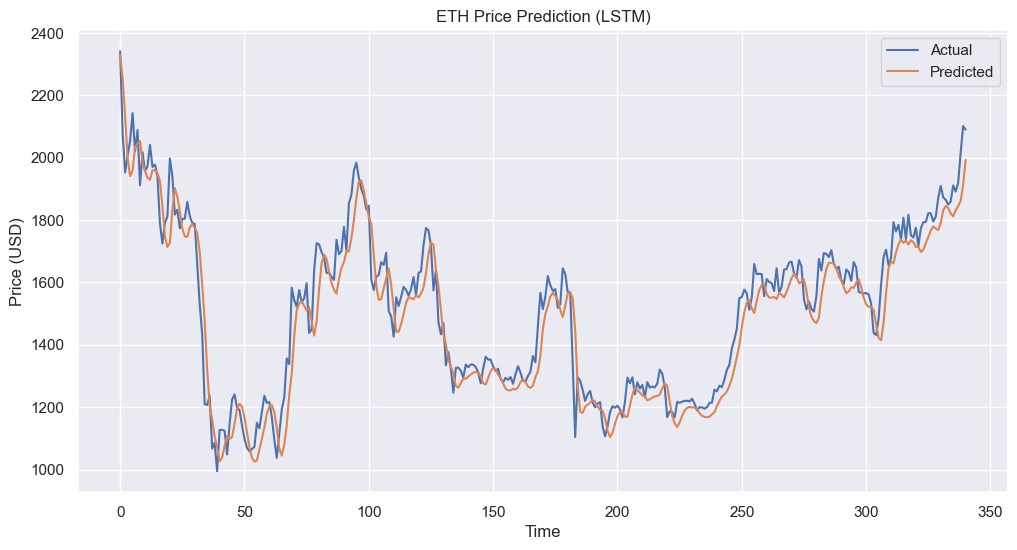

In [50]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title(f'{SYM} Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

### ```Is this data and modelling predictions accurate? 🤷``` ###